# Meter-specific LGBM for ASHRAE

This is a modified version of [this other kernel](https://www.kaggle.com/michelezoccali/ashrae-energy-prediction-single-model) with meter-specific models rather than a single one, in an attempt to capture effects on consumption specific to each meter type.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import os
import datetime
import warnings
import gc

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import lightgbm as lgb

from tqdm.notebook import tqdm

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = '../input/ashrae-energy-prediction'

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/ashrae-energy-prediction/sample_submission.csv
../input/ashrae-energy-prediction/building_metadata.csv
../input/ashrae-energy-prediction/weather_train.csv
../input/ashrae-energy-prediction/weather_test.csv
../input/ashrae-energy-prediction/train.csv
../input/ashrae-energy-prediction/test.csv


# Utilities

Memory reduction adapted from [this kernel.](https://www.kaggle.com/purist1024/ashrae-simple-data-cleanup-lb-1-08-no-leaks/notebook)

In [3]:
def reduce_mem(df):
    result = df.copy()
    for col in result.columns:
        col_data = result[col]
        dn = col_data.dtype.name
        if not dn.startswith("datetime"):  # avoid changing datetime
            if dn == "object":  # only object features have low cardinality
                result[col] = pd.to_numeric(col_data.astype("category").cat.codes, downcast="unsigned")
            elif dn.startswith("int") | dn.startswith("uint"):
                if col_data.min() >= 0:
                    result[col] = pd.to_numeric(col_data, downcast="unsigned")
                else:
                    result[col] = pd.to_numeric(col_data, downcast='integer')
            else:
                result[col] = pd.to_numeric(col_data, downcast='float')
    return result

Routine to add lag features to weather dataset, adapted from [this kernel](https://www.kaggle.com/corochann/ashrae-training-lgbm-by-meter-type/notebook).

In [4]:
def add_lag_features(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
    return weather_df

# Load data

In [5]:
def load_data(source='train'):
    assert source in ['train','test']
    df = pd.read_csv(f'{path}/{source}.csv', parse_dates=['timestamp'])
    return reduce_mem(df)

def load_building():
    df = pd.read_csv(f'{path}/building_metadata.csv').fillna(-1)
    return reduce_mem(df)

def load_weather(source='train', fix_timezone=True, impute=True, add_lag=True):
    assert source in ['train','test']
    df = pd.read_csv(f'{path}/weather_{source}.csv', parse_dates=['timestamp'])
    if fix_timezone:
        offsets = [5,0,9,6,8,0,6,6,5,7,8,6,0,7,6,6]
        offset_map = {site: offset for site, offset in enumerate(offsets)}
        df.timestamp = df.timestamp - pd.to_timedelta(df.site_id.map(offset_map), unit='h')
    if impute:
        site_dfs = []
        for site in df.site_id.unique():
            if source == 'train':
                new_idx = pd.date_range(start='2016-1-1', end='2016-12-31-23', freq='H')
            else:
                new_idx = pd.date_range(start='2017-1-1', end='2018-12-31-23', freq='H')
            site_df = df[df.site_id == site].set_index('timestamp').reindex(new_idx)
            site_df.site_id = site
            for col in [c for c in site_df.columns if c != 'site_id']:
                site_df[col] = site_df[col].interpolate(limit_direction='both', method='linear')
                site_df[col] = site_df[col].fillna(df[col].median())
            site_dfs.append(site_df)
        df = pd.concat(site_dfs)
        df['timestamp'] = df.index
        df = df.reset_index(drop=True)
        
    if add_lag:
        df = add_lag_features(df, window=3)
    
    return reduce_mem(df)

def merged_dfs(source='train', fix_timezone=True, impute=True, add_lag=True):
    df = load_data(source=source).merge(load_building(), on='building_id', how='left')
    df = df.merge(load_weather(source=source, fix_timezone=True, impute=True, add_lag=True),
                 on=['site_id','timestamp'], how='left')
    if source == 'train':
        X = df.drop('meter_reading', axis=1)  
        y = np.log1p(df.meter_reading)  # log-transform of target
        return X, y
    elif source == 'test':
        return df

In [6]:
%%time
X_train, y_train = merged_dfs()
X_train.head()

CPU times: user 18 s, sys: 2.27 s, total: 20.3 s
Wall time: 25.5 s


,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,air_temperature_max_lag3,cloud_coverage_min_lag3,cloud_coverage_mean_lag3,cloud_coverage_max_lag3,dew_temperature_min_lag3,dew_temperature_mean_lag3,dew_temperature_max_lag3,precip_depth_1_hr_min_lag3,precip_depth_1_hr_mean_lag3,precip_depth_1_hr_max_lag3
0,0,0,2016-01-01,0,0,7432,2008.0,-1.0,19.4,6.0,...,19.40625,6.0,6.0,6.0,19.40625,19.40625,19.40625,0.0,0.0,0.0
1,1,0,2016-01-01,0,0,2720,2004.0,-1.0,19.4,6.0,...,19.40625,6.0,6.0,6.0,19.40625,19.40625,19.40625,0.0,0.0,0.0
2,2,0,2016-01-01,0,0,5376,1991.0,-1.0,19.4,6.0,...,19.40625,6.0,6.0,6.0,19.40625,19.40625,19.40625,0.0,0.0,0.0
3,3,0,2016-01-01,0,0,23685,2002.0,-1.0,19.4,6.0,...,19.40625,6.0,6.0,6.0,19.40625,19.40625,19.40625,0.0,0.0,0.0
4,4,0,2016-01-01,0,0,116607,1975.0,-1.0,19.4,6.0,...,19.40625,6.0,6.0,6.0,19.40625,19.40625,19.40625,0.0,0.0,0.0


In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 27 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   building_id                  uint16        
 1   meter                        uint8         
 2   timestamp                    datetime64[ns]
 3   site_id                      uint8         
 4   primary_use                  uint8         
 5   square_feet                  uint32        
 6   year_built                   float32       
 7   floor_count                  float32       
 8   air_temperature              float32       
 9   cloud_coverage               float32       
 10  dew_temperature              float32       
 11  precip_depth_1_hr            float32       
 12  sea_level_pressure           float32       
 13  wind_direction               float32       
 14  wind_speed                   float32       
 15  air_temperature_min_lag3     float16       
 16

This corresponds to more than 50% improvement in memory usage! Plus, we have already filled time gaps and missing values.

# Preprocessing

Let us remove the first 141 days of electrical meter readings at site 0, which are mostly zero or contain anomalous spikes.

In [8]:
def _delete_bad_sitezero(X, y):
    cond = (X.timestamp > '2016-05-20') | (X.site_id != 0) | (X.meter != 0)
    X = X[cond]
    y = y.reindex_like(X)
    return X.reset_index(drop=True), y.reset_index(drop=True)

def _extract_temporal(X):
    X['hour'] = X.timestamp.dt.hour
    X['weekday'] = X.timestamp.dt.weekday
    # month and year cause overfit, could try other (holiday, business, etc.)
    return reduce_mem(X)

In [9]:
# preprocessing
X_train, y_train = _delete_bad_sitezero(X_train, y_train)
X_train = _extract_temporal(X_train)

# remove timestamp and other unimportant features
to_drop = ['timestamp','sea_level_pressure','wind_direction','wind_speed']
X_train.drop(to_drop, axis=1, inplace=True)

gc.collect()

57

# Modeling (one model per meter)

Let us write a small wrapper for LGBM, to pass to a CV routine.

In [10]:
def LGBM_wrapper(Xt, yt, Xv, yv, fold=-1):
    
    cat_features = ['building_id','site_id','primary_use','hour','weekday']
    
    dset = lgb.Dataset(Xt, label=yt, categorical_feature=cat_features)
    dset_val = lgb.Dataset(Xv, label=yv, categorical_feature=cat_features)
    
    params = {
        "objective": "regression",
        "boosting": "gbdt",
        "num_leaves": 40,
        "learning_rate": 0.05,
        "feature_fraction": 0.85,
        "reg_lambda": 2,
        "metric": "rmse",
        "verbose": -1
    }
    
    print(f'Fold {fold}')
    
    # filter some known warnings (open issue at https://github.com/microsoft/LightGBM/issues/3379)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", "categorical_column in param dict is overridden")
        warnings.filterwarnings("ignore", "Overriding the parameters from Reference Dataset")
        model = lgb.train(params,
                         train_set=dset,
                         num_boost_round=1000,
                         valid_sets=[dset, dset_val],
                         verbose_eval=200,
                         early_stopping_rounds=100,
                         categorical_feature=cat_features)
    
    oof = model.predict(Xv, num_iteration=model.best_iteration)
    score = np.sqrt(mean_squared_error(yv, oof))
    print(f'Fold {fold} RMSLE: {score}\n')
    return model, oof, score

Let's train a model for each meter, to maximise meter-specific learning (at the expense for interaction effects between meter types). 

For each model we perform k-fold CV, without shuffling as this is a time series. An alternative would be to do a single train/validation split, possibly with a gap to mimic training/private split.

In [11]:
def CV_per_meter(n_splits=3):  
    
    oof_total = np.zeros(X_train.shape[0])

    kf = KFold(n_splits=n_splits, shuffle=False)
    models = {}
    scores = {}

    for meter in tqdm(X_train.meter.sort_values().unique()):

        print(f'TRAINING MODEL FOR METER {meter}')
        X_train_meter = X_train[X_train.meter==meter].drop(columns='meter')
        y_train_meter = y_train.reindex_like(X_train_meter)

        models[meter] = []
        scores[meter] = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_meter), start=1):
            Xt, yt = X_train_meter.iloc[train_idx], y_train_meter.iloc[train_idx]
            Xv, yv = X_train_meter.iloc[val_idx], y_train_meter.iloc[val_idx]
            model, oof, score = LGBM_wrapper(Xt, yt, Xv, yv, fold)

            models[meter].append(model)
            scores[meter].append(score)
            oof_total[X_train_meter.index[val_idx]] = oof

        rmsle_meter = np.sqrt(mean_squared_error(y_train_meter, oof_total[y_train_meter.index]))
        
        print(f'> Mean RMSLE for meter {meter}: {np.mean(scores[meter])}, std: {np.std(scores[meter])}')
        print(f'> OOF RMSLE for meter {meter}: {rmsle_meter}\n')
    print('Training completed.')
    return models, scores, oof_total

In [12]:
n_splits = 3
models, scores, oof_total = CV_per_meter(n_splits=n_splits)

  0%|          | 0/4 [00:00<?, ?it/s]

TRAINING MODEL FOR METER 0
Fold 1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	training's rmse: 0.604227	valid_1's rmse: 0.697048
Fold 1 RMSLE: 0.6970482462337642

Fold 2
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.516879	valid_1's rmse: 0.675298
Early stopping, best iteration is:
[105]	training's rmse: 0.557333	valid_1's rmse: 0.664321
Fold 2 RMSLE: 0.6643209034723367

Fold 3
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.469432	valid_1's rmse: 0.754163
Early stopping, best iteration is:
[102]	training's rmse: 0.518205	valid_1's rmse: 0.749747
Fold 3 RMSLE: 0.7497471979801242

> Mean RMSLE for meter 0: 0.7037054492287417, std: 0.035191397737894835
> OOF RMSLE for meter 0: 0.7045848338860609

TRAINING MODEL FOR METER 1
Fold 1
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 1.0692	valid_1's rmse: 1.37687
[400]	tr

In [13]:
print(f'TOTAL OOF RMSLE: {np.sqrt(mean_squared_error(y_train, oof_total))}')

TOTAL OOF RMSLE: 1.0934944878619095


## Feature importance

Let's see the average feature importance across models (per meter type). We can use this to retroactively drop further superfluous features during preprocessing.

In [14]:
def plot_importance(meter):    
    importance = pd.DataFrame([model.feature_importance() for model in models[meter]],
                              columns=X_train.drop(columns='meter').columns,
                              index=[f'Fold {i}' for i in range(1, n_splits + 1)])
    importance = importance.T
    importance['Average importance'] = importance.mean(axis=1)
    importance = importance.sort_values(by='Average importance', ascending=False)

    plt.figure(figsize=(10,7))
    sns.barplot(x='Average importance', y=importance.index, data=importance);

Let's plot it for e.g. meter 3:

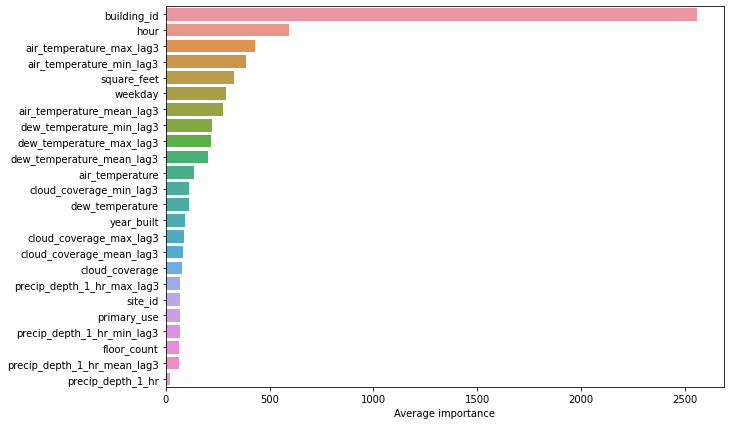

In [15]:
plot_importance(3)

In [16]:
del X_train, y_train
gc.collect()

7601

# Test set, inference and submission

In [17]:
%%time
X_test = merged_dfs('test')

CPU times: user 53.3 s, sys: 3.36 s, total: 56.7 s
Wall time: 1min 7s


In [18]:
row_ids = X_test.row_id # for submission file
X_test = _extract_temporal(X_test)
X_test.drop(columns=['row_id','timestamp']+to_drop, inplace=True)

gc.collect()

34

In [19]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 25 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   building_id                  uint16 
 1   meter                        uint8  
 2   site_id                      uint8  
 3   primary_use                  uint8  
 4   square_feet                  uint32 
 5   year_built                   float32
 6   floor_count                  float32
 7   air_temperature              float32
 8   cloud_coverage               float32
 9   dew_temperature              float32
 10  precip_depth_1_hr            float32
 11  air_temperature_min_lag3     float16
 12  air_temperature_mean_lag3    float16
 13  air_temperature_max_lag3     float16
 14  cloud_coverage_min_lag3      float16
 15  cloud_coverage_mean_lag3     float16
 16  cloud_coverage_max_lag3      float16
 17  dew_temperature_min_lag3     float16
 18  dew_temperature_mean_lag3    float16
 19

For each meter, we compute the predictions on the test set for each CV model, then average the results. We split the computation in batches, to keep memory usage within the limits. Naturally, we transform the predictions back into linear space with the inverse of the log-transform.

In [20]:
def get_preds(n_iterations=5):   
    
    all_preds = np.zeros(X_test.shape[0])
    
    for meter in range(4):

        X_test_meter = X_test[X_test.meter == meter].drop(columns='meter')
        batch_size = len(X_test_meter) // n_iterations
        preds = []

        print(f'Getting predictions for meter {meter}...')
        for i in tqdm(range(n_iterations)):
            start = i * batch_size
            fold_preds = [np.expm1(model.predict(X_test_meter.iloc[start:start + batch_size], 
                             num_iteration=model.best_iteration)) for model in models[meter]]
            preds.extend(np.mean(fold_preds, axis=0))

        all_preds[X_test_meter.index] = preds
        
    return all_preds

all_preds = get_preds()

Getting predictions for meter 0...


  0%|          | 0/5 [00:00<?, ?it/s]

Getting predictions for meter 1...


  0%|          | 0/5 [00:00<?, ?it/s]

Getting predictions for meter 2...


  0%|          | 0/5 [00:00<?, ?it/s]

Getting predictions for meter 3...


  0%|          | 0/5 [00:00<?, ?it/s]

In [21]:
del X_test
gc.collect()

80

Finally, save for submission and hope for the best.

In [22]:
submission = pd.DataFrame({'row_id':row_ids, 'meter_reading':np.clip(all_preds, 0, a_max=None)})
submission.to_csv('submission.csv', index=False)

We can check that the distribution of the predictions looks reasonable:

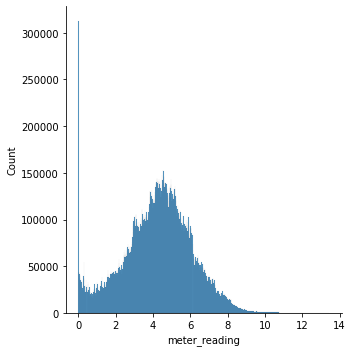

In [23]:
sns.displot(np.log1p(submission.meter_reading));